<a href="https://colab.research.google.com/github/YuToyoshima/RoiEdit3D/blob/main/gel_analysis_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**電気泳動ゲル画像を読み込んで表示してみましょう**

im_raw.shape  (1, 467, 276)
im.shape (467, 276)


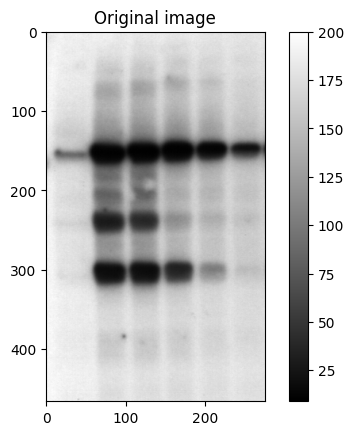

In [ ]:
# 必要なライブラリをインポート
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from skimage.io import imread

# サンプルのゲル画像をURLから読み込み
im_raw = imread('https://imagej.net/images/gel.gif')
print("im_raw.shape ",im_raw.shape) # サイズを確認すると、(1,467,276)で、最初の次元が余分
im = im_raw.reshape(im_raw.shape[1],im_raw.shape[2]) # 最初の次元をなくす
print("im.shape",im.shape) # サイズを確認

# 画像を表示（グレースケール）
plt.figure()
plt.imshow(im, cmap='gray')
plt.axis('image')       # アスペクト比を保持
plt.colorbar()          # カラーバーを追加
plt.title('Original image')
plt.show()


**ImageJ マクロと同じ処理をしてみましょう**

In [ ]:
# for (p=0; p<6; p++) {
#   makeRectangle(10+45*p, 135, 45, 40);
#       roiManager("Add");
# }
# roiManager("Measure");
intensity = np.zeros(6) # 6つの要素を持つ配列を先に作っておく
for p in range(6): # forループ
  # pythonで読み込んだ画像は1次元目が行(高さ)、2次元目が列(幅)になる
  #高さ 135 から 135+40, 幅 10+45*p から 10+45*p+45 を選ぶ
  print("p",p) # pはゼロから始まることを確認(0-based)
  roi = im[135:135+40, (10+45*p):(10+45*p)+45]
  intensity[p] = np.mean(roi) # 平均輝度を計算

print("intensity:",intensity)

p 0
p 1
p 2
p 3
p 4
p 5
intensity: [136.38944444  45.19111111  45.10833333  53.24888889  74.49166667
  94.25304878]


**肩慣らしとして、1から10までを足して表示するコードを書いてみましょう**

できるだけ色々な書き方を試してみてください

In [20]:
print(1+2+3+4+5+6+7+8+9+10)
###### 以下に記載

print((1+10)*10/2)
print(np.sum(range(10+1)))



55
55.0
55


**電気泳動ゲル画像からレーンとバンドを検出して定量してみましょう**

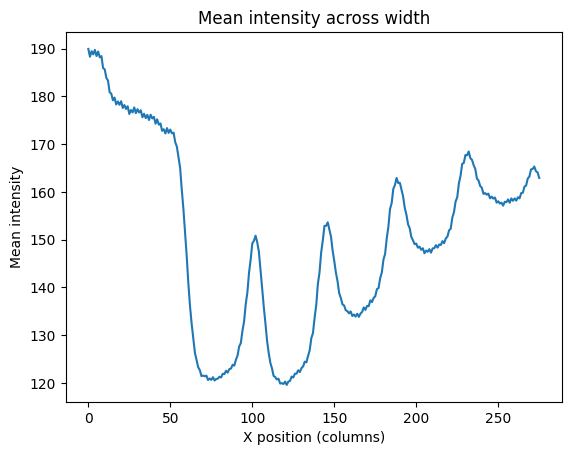

In [ ]:
# 画像の列方向（x方向）の平均強度を計算
xMean = im.mean(axis=0)

plt.figure()
plt.plot(xMean)
plt.title('Mean intensity across width')
plt.xlabel('X position (columns)')
plt.ylabel('Mean intensity')
plt.show()

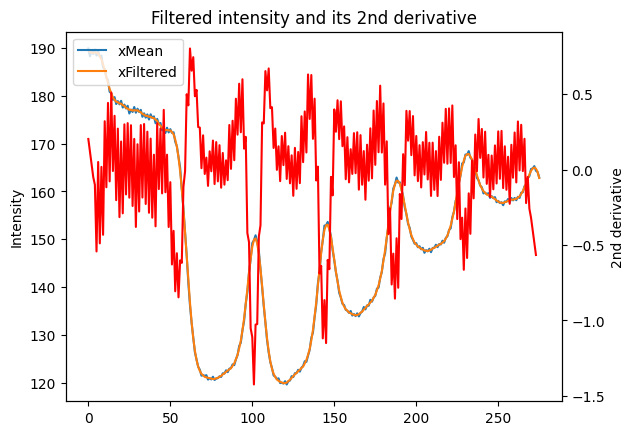

In [ ]:
# Savitzky-Golayフィルタで平滑化（3次多項式, 窓幅11）
xFiltered = savgol_filter(xMean, window_length=11, polyorder=3)

# 2階微分を計算（レーン境界を強調）
xDiff = np.diff(xFiltered, n=2)

# 両軸表示
# 左軸：元の平均値／平滑化値、右軸：2階微分値
fig, ax1 = plt.subplots()
ax1.plot(xMean, label='xMean')
ax1.plot(xFiltered, label='xFiltered')
ax1.set_ylabel('Intensity')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(xDiff, 'r', label='xDiff (2nd derivative)')
ax2.set_ylabel('2nd derivative')
plt.title('Filtered intensity and its 2nd derivative')
plt.show()

Detected lane boundaries (x positions): [  5  55 101 145 187 229 267]


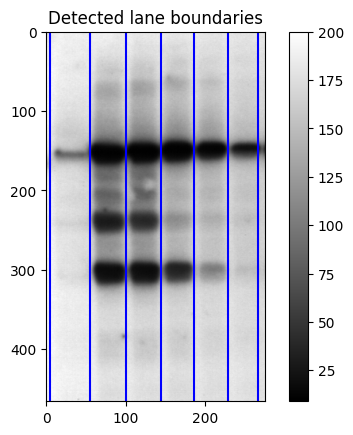

In [ ]:
# 2階微分の負値からピークを検出（レーン境界の候補）
locsX = find_peaks(-xDiff, distance=30)[0]
print(f"Detected lane boundaries (x positions): {locsX}")

# 検出されたレーン境界を画像上に重ねて表示
plt.figure()
plt.imshow(im, cmap='gray')
plt.axis('image')
plt.colorbar()
for l in locsX:
    plt.axvline(x=l, color='b', linestyle='-')
plt.title('Detected lane boundaries')
plt.show()

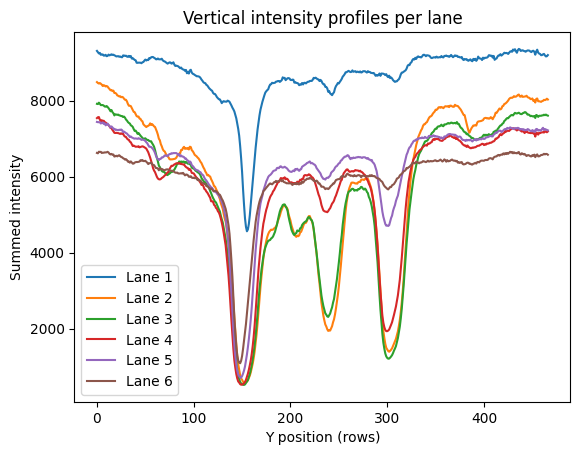

In [ ]:
# レーン数を計算（境界線の間隔で定義）
numLanes = len(locsX) - 1
height, width = im.shape

# 各レーン領域の縦方向強度プロファイルを計算
yProfile = np.zeros((height, numLanes))
for p in range(numLanes):
    # locsX[p] 〜 locsX[p+1] の列を合計（1レーン分）
    yProfile[:, p] = im[:, locsX[p]+1:locsX[p+1]].sum(axis=1)

plt.figure()
for p in range(numLanes):
    plt.plot(yProfile[:, p], label=f'Lane {p+1}')  # 各レーンにラベルを付与
plt.title('Vertical intensity profiles per lane')
plt.xlabel('Y position (rows)')
plt.ylabel('Summed intensity')
plt.legend()  # 凡例を表示
plt.show()

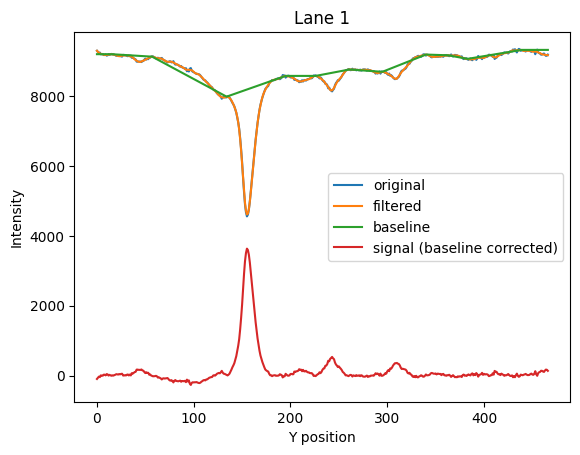

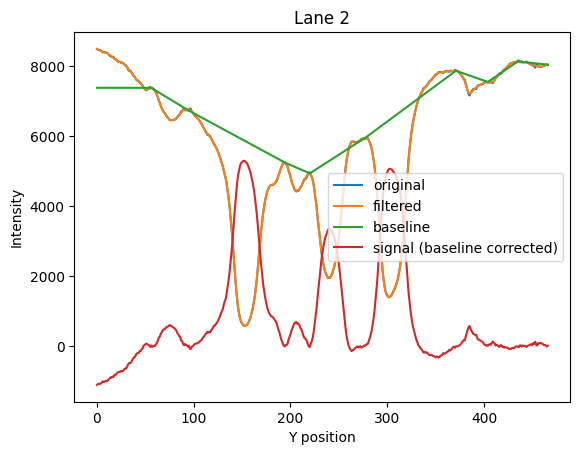

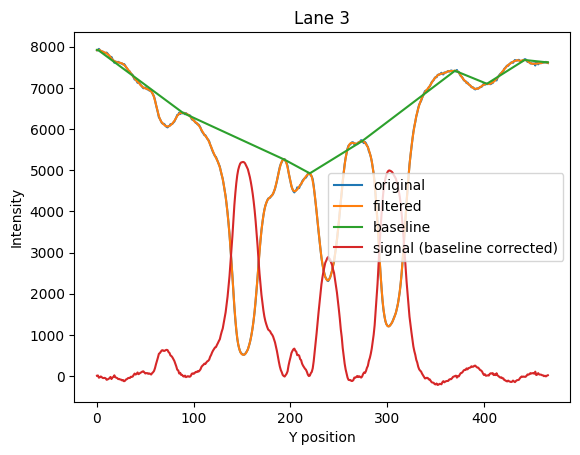

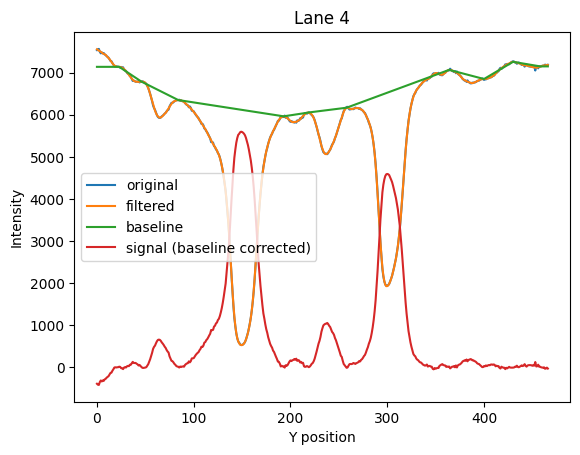

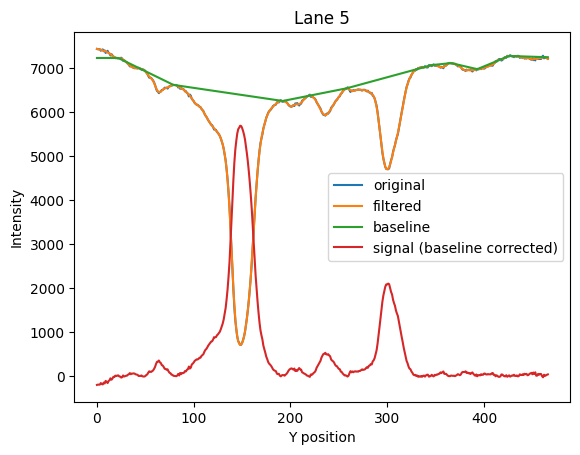

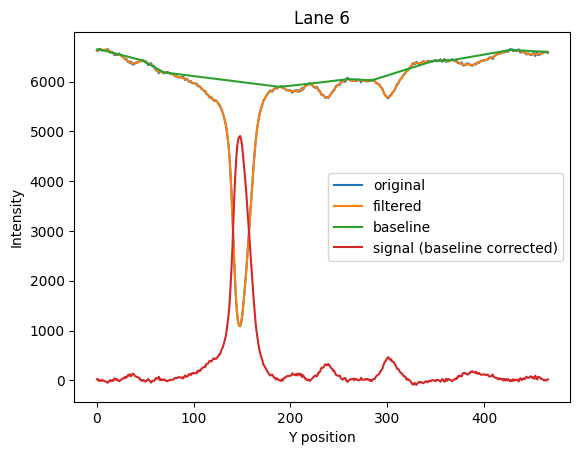

In [ ]:
# 各レーン内でピーク検出（バンド検出）
ySignal = np.zeros_like(yProfile)
locsYAll = []

for p in range(numLanes):
    # Savitzky-Golayフィルタで縦方向プロファイルを平滑化
    yFiltered = savgol_filter(yProfile[:, p], window_length=11, polyorder=3)

    # ピーク検出（距離=20ピクセル）
    locsY = find_peaks(yFiltered, distance=20)[0]
    locsYAll.append(locsY)

    # 検出されたピークをもとにベースラインを補間
    baseline = np.interp(np.arange(height), locsY, yFiltered[locsY])

    # ベースライン補正：シグナル = -(元データ - ベースライン)
    ySignal[:, p] = -(yProfile[:, p] - baseline)

    # 各レーンごとの可視化
    plt.figure()
    plt.plot(yProfile[:, p], label='original')
    plt.plot(yFiltered, label='filtered')
    plt.plot(baseline, label='baseline')
    plt.plot(ySignal[:, p], label='signal (baseline corrected)')
    plt.title(f'Lane {p+1}')
    plt.xlabel('Y position')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()


**課題1 ゲル画像に重ねて、各レーンのバンドの境界を表示してみてください**


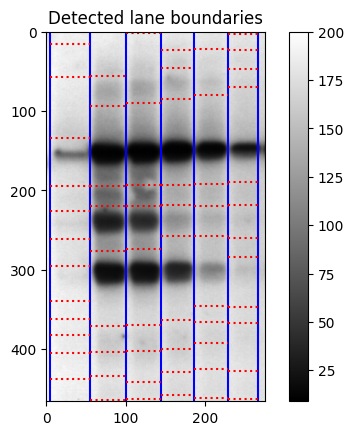

In [ ]:
# 検出されたレーン境界を画像上に重ねて表示
plt.figure()
plt.imshow(im, cmap='gray')
plt.axis('image')
plt.colorbar()
for l in locsX:
    plt.axvline(x=l, color='b', linestyle='-')

###### ここに記載
###### ヒント: バンドの境界はlocsYAllにまとめて保存されています
###### ヒント2: pレーン目のバンドの情報を取り出したいときは locsYAll[p-1] とします

for p in range(numLanes):
  locsY=locsYAll[p]
  for q in locsY:
    plt.plot(locsX[p:p+2],[q,q],'r:')

plt.title('Detected lane boundaries')
plt.show()

**課題2 y=150, y=250, y=300付近にあるバンドの濃さをグラフにしてみましょう**

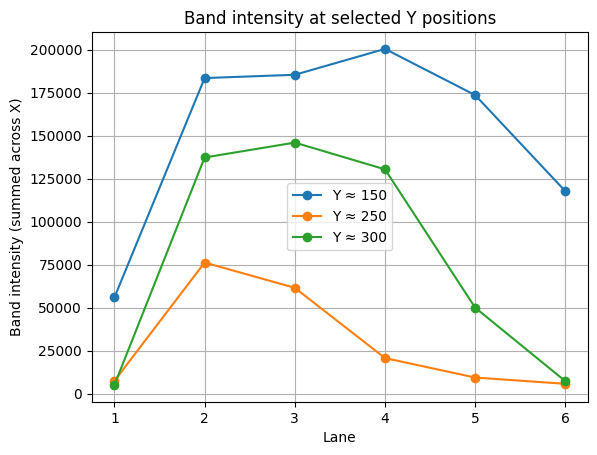

In [ ]:
# バンド濃さを取得したいy座標
yTarget = [150, 250, 300]
numTarget = 3

# レーン数とyProfileの高さを取得
numLanes = yProfile.shape[1]

# バンドの濃さを保存する配列
band_intensity = np.zeros([3,numLanes])

###### 以下に記載
###### ヒント: ySignalについて、バンドの境界から次の境界までの総和を計算

# 各レーンについて
for p in range(numLanes):
    profile = yProfile[:, p]
    locsY=locsYAll[p]
    for q in range(len(locsY)-1):
      for r in range(numTarget):
        if locsY[q]<yTarget[r] and locsY[q+1]>=yTarget[r]:
          band_intensity[r,p] = sum(ySignal[locsY[q]:locsY[q+1],p])


# グラフ化
plt.figure()
for r in range(numTarget):
    plt.plot(range(1, numLanes+1), band_intensity[r], marker='o', label=f'Y ≈ {yTarget[r]}')

plt.xlabel('Lane')
plt.ylabel('Band intensity (summed across X)')
plt.title('Band intensity at selected Y positions')
plt.xticks(range(1, numLanes+1))
plt.legend()
plt.grid(True)
plt.show()
